This notebook runs the event segmentation analyses.

## Import libraries

In [5]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pickle
from scipy.stats import wasserstein_distance

def score_model(mcorr, model, k, s):
    i1, i2 = np.where(np.round(model.segments_[0])==1)
    w = np.zeros_like(model.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return mcorr[w].mean()/mcorr[~w].mean() - k/s
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

%matplotlib inline

## Setting paths

In [6]:
datadir = '../../../data/processed/'

## Load data

In [7]:
video_model, recall_models = np.load(datadir+'models_t100_v50_r10.npy')

## Find optimal k for video model

In [4]:
nEvents = np.arange(2,51)
wd = np.zeros(len(nEvents))
corrmat = np.corrcoef(video_model)

for i, events in enumerate(nEvents):
    ev = event.EventSegment(events)
    ev.fit(video_model)
    t = np.round(ev.segments_[0]).astype(int)
    mask = np.sum(list(map(lambda x: np.outer(x, x), t.T)), 0).astype(bool)

    # Create mask such that the maximum temporal distance for # within and across correlations is the same
    local_mask = np.zeros(mask.shape, dtype=bool)
    for k in range(mask.shape[0]):
        if ~np.any(np.diag(mask,k)):
            break
        local_mask[np.diag(np.ones(local_mask.shape[0]-k, dtype=bool), k)] = True
    within_vals = np.reshape(corrmat[mask*local_mask], -1, 1) 
    across_vals = np.reshape(corrmat[~mask*local_mask], -1, 1)
    wd[i] = wasserstein_distance(within_vals, across_vals)
    print(events, wd[i])

2 0.11855123884018658
3 0.1802099739189293
4 0.24032636126342904
5 0.28166573307316467
6 0.32078268855555786
7 0.3409815313664513
8 0.3868730785969222
9 0.42479999766584836
10 0.46383957305791235
11 0.49526921075092867
12 0.5143642787129715
13 0.5424667946803853
14 0.5304001796847251
15 0.5870711923386918
16 0.5618820573374081
17 0.5728606305027543
18 0.5927475399252785
19 0.6028292968557177
20 0.6298211472976497
21 0.5760406215486921
22 0.6269885941488806
23 0.618971479586085
24 0.617239192647575
25 0.6066725611032758
26 0.6231600679910951
27 0.622932124217396
28 0.6033100714522347
29 0.6147365726845316
30 0.5967332082045416
31 0.6060240108561631
32 0.6012695417012687
33 0.5986004910914631
34 0.5921259078742087
35 0.5895942561130582
36 0.5979106408571768
37 0.5894246480653847
38 0.5905904021246919
39 0.5892662729079396
40 0.589264949080081
41 0.5977751867234239
42 0.5350684162049885
43 0.5956324924231043
44 0.533787804460494
45 0.5307122831239645
46 0.5285885129516545
47 0.52644740481

## Plot the within and across correlation values as a function of k

20


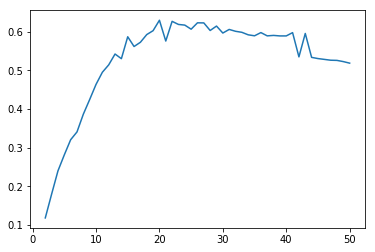

In [5]:
plt.plot(nEvents, wd)
maxk_video = nEvents[np.argmax(wd)]
print(maxk_video)

## Plot the ratio of within/across ratio as a function of k

## Fit event segmentation model to video

In [6]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [7]:
with open(datadir+'/video_eventseg_model_wasserstein', 'wb') as f:
    pickle.dump(ev, f)
np.save(datadir+'video_events_wasserstein', video_events)

## Get video event times

In [8]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(datadir+'video_event_times_wasserstein', video_event_times)

## Fit event segmentation model to recall

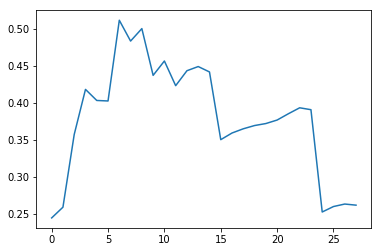

0 8


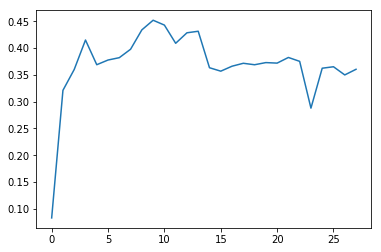

1 11


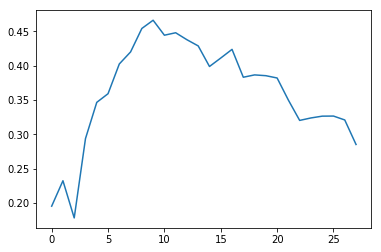

2 11


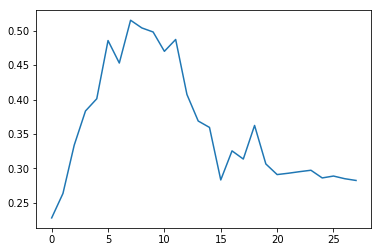

3 9


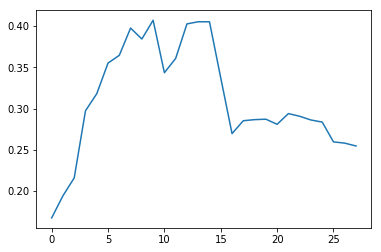

4 11


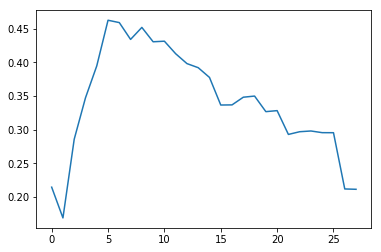

5 7


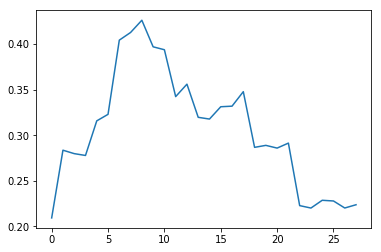

6 10


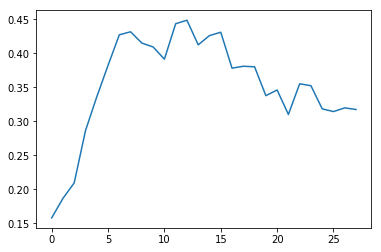

7 14


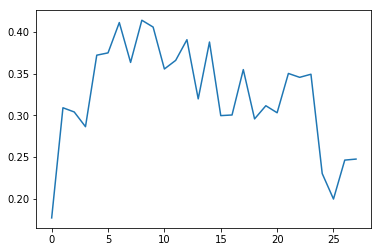

8 10


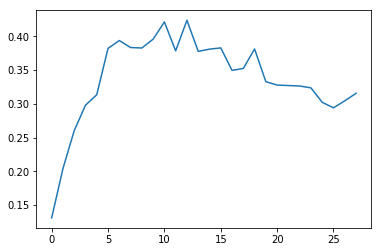

9 14


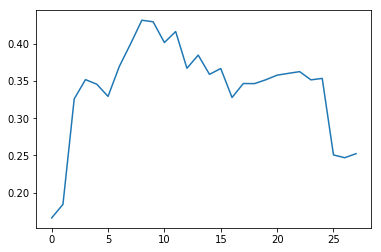

10 10


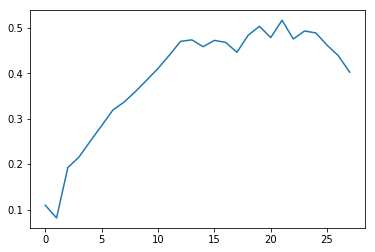

11 23


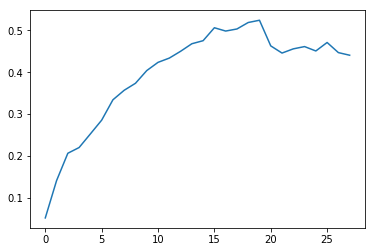

12 21


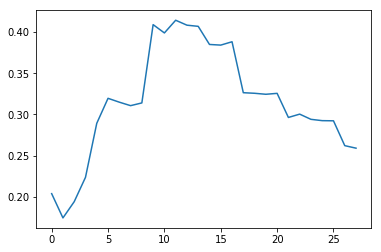

13 13


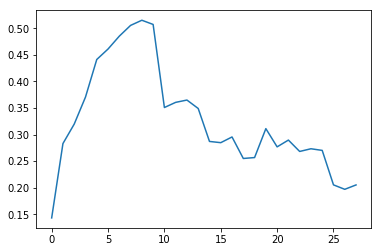

14 10


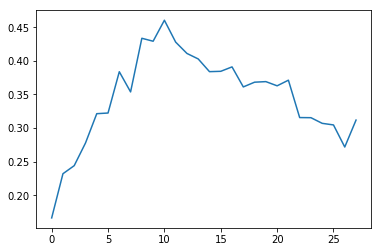

15 12


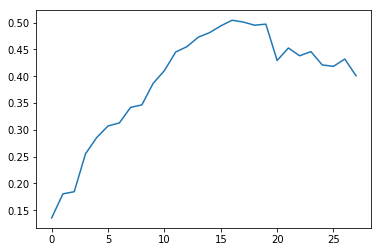

16 18


In [8]:
from scipy.stats import pearsonr as corr

ks = list(range(2, 30))
maxk = []
for i, sub in enumerate(recall_models):
    mcorr = np.corrcoef(sub)
    cs = []
    for k in ks:
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        mask = np.dot(w, w.T).astype(bool)
        
        # Create mask such that the maximum temporal distance for # within and across correlations is the same
        local_mask = np.zeros(mask.shape, dtype=bool)
        for m in range(mask.shape[0]):
            if ~np.any(np.diag(mask, m)):
                break
            local_mask[np.diag(np.ones(local_mask.shape[0]-m, dtype=bool), m)] = True
        within_vals = np.reshape(mcorr[mask*local_mask], -1, 1) 
        across_vals = np.reshape(mcorr[~mask*local_mask], -1, 1)
        cs.append(wasserstein_distance(within_vals, across_vals))
    plt.plot(cs)
    plt.show()
    m = ks[np.argmax(cs)]
    maxk.append(m)
    print(i, m)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


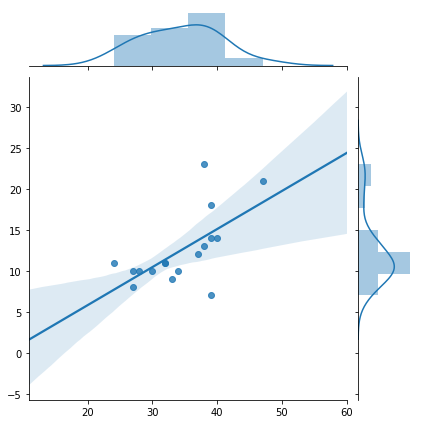

In [13]:
hand_rec = [27, 24, 32, 33, 32, 39, 30, 39, 28, 40, 34, 38, 47, 38, 27, 37, 39]
sns.jointplot(hand_rec, maxk, kind = 'reg', order = 1)

## Fit model to recall using best k

In [14]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [14]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))
avg_recall_events = np.array([a.reshape(100,) for a in avg_recall_events if a.shape==(100,)])

## Create 2D embeddings

In [12]:
np.random.seed(10)
embeddings = hyp.reduce(recall_events+[video_events]+[avg_recall_events], reduce='UMAP', ndims=2)

## Save models

In [16]:
np.save(datadir+'avg_recall_events_wasserstein', avg_recall_events)
np.save(datadir+'embeddings_wasserstein', [embeddings[:-2], embeddings[-2], embeddings[-1]])
np.save(datadir+'labels_wasserstein', matches)
np.save(datadir+'video_events_wasserstein', video_events)
np.save(datadir+'recall_events_wasserstein', recall_events)
np.save(datadir+'recall_event_times_wasserstein', recall_event_times)
with open(datadir+'recall_eventseg_models_wasserstein', 'wb') as f:
    pickle.dump(recall_eventseg_models, f)

NameError: name 'recall_eventseg_models' is not defined

In [ ]:
video_events = np.load(datadir+'video_events_wasserstein')
recall_events
avg_recall_events = np.load(datadir+'avg_recall_events_wasserstein')